# Tracking Sensor Bias

We want to compute the joint posterior over sensors' biases in a 2-D tracking setting.

In [2]:
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.optim import Adam

import pyro
import pyro.distributions as dist

import funsor
import funsor.pyro
import funsor.distributions as f_dist
import funsor.ops as ops
from funsor.pyro.convert import dist_to_funsor, mvn_to_funsor, matrix_and_mvn_to_funsor, tensor_to_funsor
from funsor.interpreter import interpretation, reinterpret
from funsor.optimizer import apply_optimizer
from funsor.terms import lazy, eager_or_die
from funsor.domains import bint, reals
from funsor.torch import Tensor, Variable
from funsor.gaussian import Gaussian
from funsor.sum_product import sequential_sum_product

import matplotlib.pyplot as plt

Simulate some synthetic data:

In [3]:
num_sensors = 5
num_frames = 100

# simulate biased sensors
sensors  = []
for _ in range(num_sensors):
    bias = 0.5 * torch.randn(2)
    sensors.append(bias)

# simulate a single track
# TODO heterogeneous time
partial_obs = []
z = 10 * torch.rand(2)  # initial state
v = 2 * torch.randn(2)  # velocity
for t in range(num_frames):
    # Advance latent state.
    z += v + 0.1 * torch.randn(2)
#     z.clamp_(min=0, max=10)  # keep in the box
    
    # Observe via a random sensor.
    sensor_id = pyro.sample('id', dist.Categorical(torch.ones(num_sensors)))
    x = z - sensors[sensor_id]
    partial_obs.append({"sensor_id": sensor_id, "x": x})
    
# simulate all tracks
full_observations = []
z = 10 * torch.rand(5, 2)  # initial state
v = 2 * torch.randn(5, 2)  # velocity
for t in range(num_frames):
    # Advance latent state.
    z += v + 0.1 * torch.randn(5, 2)
#     z.clamp_(min=0, max=10)  # keep in the box
    
    # Observe via a random sensor.
    x = z - torch.stack(sensors)
    full_observations.append(x)
full_observations = torch.stack(full_observations)
assert full_observations.shape == (num_frames, 5, 2)
full_observations = Tensor(full_observations)["time"]

Now let's set up a tracking problem in Funsor. We start by modeling the biases of each sensor.

In [4]:
# TODO transform this to cholesky decomposition
# print(bias_cov.shape)
# bias_cov = bias_cov @ bias_cov.t()
# create a joint Gaussian over biases

# covs = [torch.eye(2, requires_grad=True) for i in range(num_sensors)]
# bias_dist = 0.
# for i in range(num_sensors):
#     bias += funsor.pyro.convert.mvn_to_funsor(
#         dist.MultivariateNormal(torch.zeros(2), covs[i]),
# #         event_dims=("pos",),
# #         real_inputs=OrderedDict([("bias_{}".format(i), reals(2))])
#         real_inputs=OrderedDict([("bias", reals(2))])
#     )(value="bias_{}".format(i))
# bias_dist.__dict__

# we can't write bias_dist as a sum of mvns because affine transformation
# of mvns is not supported yet.  instead we will combine all the sensors
# into a giant tensor
bias_scales = torch.ones(2, requires_grad=True)  # This can be learned
# bias_dist = funsor.pyro.convert.mvn_to_funsor(
#     dist.MultivariateNormal(
#         torch.zeros(num_sensors * 2),
#         bias_scales.expand(num_sensors, 2).reshape(-1).diag_embed()
#     ),
#     real_inputs=OrderedDict([("bias", reals(num_sensors, 2))])
# )
# bias_dist.__dict__

Set up the filter in funsor.

In [5]:
# TODO
# this can be parameterized by a lower dimensional vector 
# to learn a structured transition matrix
# eg a GP with a matern v=3/2 kernel
# see paper for details 

# transition matrix from discretization as in 
# http://webee.technion.ac.il/people/shimkin/Estimation09/ch8_target.pdf
T = 1.  # timestep
trans_matrix_noise = torch.randn(1)  # this could be learnable
trans_dist_cov = torch.tensor([[1./3 * T ** 3, 0.5 * T ** 2],
                                  [0.5 * T ** 2, T]]) * trans_matrix_noise ** 2
transition_matrix = torch.randn(2, 2, requires_grad=True)
transition_matrix = torch.tensor([[1., T],
                                  [0, 1]])

In [6]:
# class HMM_that_would_work_if_we_had_more_patterns(nn.Module):
#     def __init__(self, num_sensors, track):
#         self.num_sensors = num_sensors
#         bias_dist = funsor.pyro.convert.mvn_to_funsor(
#             dist.MultivariateNormal(
#                 torch.zeros(num_sensors * 2),
#                 bias_scales.expand(num_sensors, 2).reshape(-1).diag_embed()
#             ),
#             real_inputs=OrderedDict([("bias", reals(num_sensors * 2))])
#         )
#         init_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
#         transition_dist = torch.distributions.MultivariateNormal(
#             torch.zeros(2), trans_dist_cov)
#         observation_matrix = torch.eye(2) + 0.2 * torch.randn(2, 2)
#         observation_matrix = (observation_matrix.unsqueeze(1)
#                                                 .expand(2, num_sensors, 2)
#                                                 .reshape(2, num_sensors * 2))
#         # this is the bias for all the sensors
#         # Note sensor_ids is no longer needed because every sensor.
#         # sensor_ids = torch.tensor([frame["sensor_id"] for frame in track])
#         bias = torch.zeros(num_sensors, 2, requires_grad=True)
#         # obs_dist will be flattened out
#         observation_dist = torch.distributions.MultivariateNormal(
#             bias.reshape(num_sensors * 2),
#             torch.eye(num_sensors * 2))

#         self.init = dist_to_funsor(init_dist)(value="state")
#         # inputs are the previous state ``state`` and the next state
#         transition_matrix = torch.randn(2, 2, requires_grad=True)
#         self.trans = matrix_and_mvn_to_funsor(transition_matrix, transition_dist,
#                                               ("time",), "state", "state(time=1)")
#         self.obs = matrix_and_mvn_to_funsor(observation_matrix, observation_dist,
#                                             ("time",), "state(time=1)", "value")
#         super(HMM, self).__init__()
    
#     def forward(self, track):
#         # we add bias to the observation as a global variable
#         # single interleaved track
#         # we expand the data which will be properly indexed by obs
#         data = torch.stack([frame["x"] for frame in track])
#         data = Tensor(data.unsqueeze(1)
#                           .expand(-1, self.num_sensors, 2)
#                           .reshape(-1, self.num_sensors * 2),
#                       OrderedDict(time=bint(len(track))))
# #         print(f"data.output = {data.output}")

#         # incorporate sensor id in the observation by creating
#         # a free variable that has the signature
#         # inputs: bias of shape (num_sensors, 2), sensor_ids
#         # outputs shape 2
#         # This is like a delayed sample statement:
#         #  bias = pyro.sample("bias", bias_dist)
#         bias = Variable("bias", reals(num_sensors * 2))
#         debiased_observations = data + bias
#         # this indexing pattern is not implemented to sub into a Gaussian
#         # https://github.com/pyro-ppl/funsor/pull/220
#         # instead, we can use matrix_and_mvn_to_funsor and index  the proper latents and just 
#         # observe naively

#         with interpretation(eager_or_die):
# #             print(f"obs.inputs['value'] = {self.obs.inputs['value']}")
#             obs = self.obs(value=debiased_observations)

#             logp = self.trans + obs + bias_dist
        
#             # collapse out the time variable
#             # TODO this can only handle homogeneous funsor types
#             logp = sequential_sum_product(ops.logaddexp, ops.add,
#                                           logp, "time", {"state": "state(time=1)"})
#             logp += init
#             # marginalize out remaining latent variables
#             logp = logp.reduce(ops.logaddexp)
            
#         # extract torch.Tensor from funsor
#         assert isinstance(logp, Tensor), logp.pretty()
#         return logp.data

In [31]:
class HMM(nn.Module):
    def __init__(self, num_sensors):
        super(HMM, self).__init__()
        self.num_sensors = num_sensors
        
    def forward(self, track):
        num_sensors = self.num_sensors
        
        bias_dist = funsor.pyro.convert.mvn_to_funsor(
            dist.MultivariateNormal(
                torch.zeros(num_sensors * 2),
                bias_scales.expand(num_sensors, 2).reshape(-1).diag_embed()
            ),
            real_inputs=OrderedDict([("bias", reals(num_sensors * 2))])
        )
        init_dist = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
        transition_dist = torch.distributions.MultivariateNormal(
            torch.zeros(2), trans_dist_cov)
        observation_matrix = torch.eye(2) + 0.2 * torch.randn(2, 2)
        observation_matrix = (observation_matrix.unsqueeze(1)
                                                .expand(2, num_sensors, 2)
                                                .reshape(2, num_sensors * 2))
        # this is the bias for all the sensors
        # Note sensor_ids is no longer needed because every sensor is observed
        # sensor_ids = torch.tensor([frame["sensor_id"] for frame in track])
        bias = torch.zeros(num_sensors * 2, requires_grad=True)
        # obs_dist will be flattened out
        observation_dist = torch.distributions.MultivariateNormal(
            bias,
            torch.eye(num_sensors * 2))

        self.init = dist_to_funsor(init_dist)(value="state")
        # inputs are the previous state ``state`` and the next state
        transition_matrix = torch.randn(2, 2, requires_grad=True)
        self.trans = matrix_and_mvn_to_funsor(transition_matrix, transition_dist,
                                              ("time",), "state", "state(time=1)")
        
        # This is what we want
        # self.obs = matrix_and_mvn_to_funsor(observation_matrix, observation_dist,
        #                                     ("time",), "state(time=1)", "value")
        # but instead we will manually insert a bias term into obs.
        bias_matrix = torch.eye(num_sensors * 2)
        obs_and_bias_matrix = torch.cat((observation_matrix, bias_matrix))
        obs = matrix_and_mvn_to_funsor(obs_and_bias_matrix, observation_dist,
                                       ("time",), "state_and_bias", "value")
        
        # HACK to replace state_and_bias with two variables.
        assert (not obs.deltas and
                isinstance(obs.discrete, Tensor) and
                isinstance(obs.gaussian, Gaussian))
        inputs = OrderedDict()
        for k, d in obs.gaussian.inputs.items():
          if k == "state_and_bias":
            assert d == reals(2 + num_sensors * 2), d
            inputs["state(time=1)"] = reals(2)
            inputs["bias"] = reals(num_sensors * 2)
          else:
            inputs[k] = d
        g = obs.gaussian
        self.obs = obs.discrete + Gaussian(g.info_vec, g.precision, inputs)
    
        # we add bias to the observation as a global variable
#         data = torch.stack([frame["x"] for frame in track])
#         data = Tensor(data.unsqueeze(1)
#                           .expand(-1, self.num_sensors, 2)
#                           .reshape(-1, self.num_sensors * 2),
#                       OrderedDict(time=bint(len(track))))
        assert isinstance(track, Tensor)
        data = Tensor(track.data.reshape(-1, self.num_sensors * 2),
                      OrderedDict(time=bint(len(track.data))))

        with interpretation(eager_or_die):
            logp = self.obs(value=data)
            logp += bias_dist + self.trans
        
            # collapse out the time variable
            # TODO this can only handle homogeneous funsor types
            logp = sequential_sum_product(ops.logaddexp, ops.add,
                                          logp, "time", {"state": "state(time=1)"})
            logp += self.init
            # marginalize out remaining latent variables
            logp = logp.reduce(ops.logaddexp)
            
        # extract torch.Tensor from funsor
        assert isinstance(logp, Tensor), logp.pretty()
        return logp.data

## Inference

Finally we have a result that is a joint Gaussian over the biases.
We can
1. optimize all parameters to maximize `result`
2. estimate the joint distribution over all bias parameters.

In [32]:
num_epochs = 200
params = [bias_scales]
params_snapshot = []
losses = []
# params.append(transition_matrix)
optim = Adam(params, lr=1e-3)
model = HMM(num_sensors)
for i in range(num_epochs):
    optim.zero_grad()
    log_prob = model(full_observations)
    loss = -log_prob
    loss.backward()
    losses.append(loss.item())
    if i % 10 == 0:
        params_snapshot.append(bias_scales.data.cpu().numpy())
        print(loss.item())
    optim.step()

3218569.25
3239593.5
3728937.75
3714278.0
3900251.75
3442537.5
3797742.25
3339201.0
3890928.5
3723316.25
3790757.25
3145000.75
3194092.75
3790083.0
3769519.25
3222397.75
3508750.5
3697958.0
2947722.75
2884709.5


In [33]:
print(params)

[tensor([1.7548, 1.7000], requires_grad=True)]


Visualize the joint posterior distribution.

### possible plots
1. plot the MSE of the MAP estimates with and without bias (or table)
2. train with and without marginalizing out bias, plot both loss curves
  - plot nll and MSE at each epoch
3. smoothing? would require adjoint algorithm `tests/test_adjoint.py`
4. 

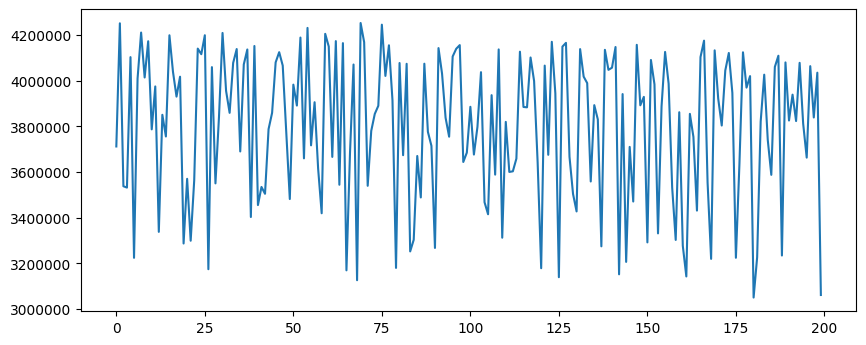

In [20]:
plt.figure(figsize=(10,4), dpi=100).set_facecolor('white')
plt.plot(losses)


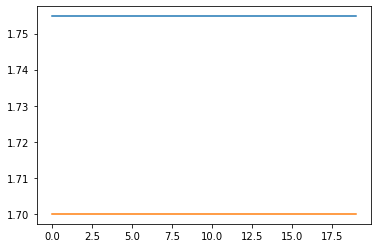

In [36]:
plt.plot(params_snapshot)

In [37]:
[params_snapshot[i] for i in range(10)]

[array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32),
 array([1.7548008, 1.6999886], dtype=float32)]